In [1]:
# Ref:https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('pymodules')
# for dictionary method synonym finder using wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import Word2Vec
# making the plot look good ...
from adjustText import adjust_text
from sklearn.decomposition import PCA

from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
from tensorflow.keras.layers import Dropout

from sklearn import metrics

# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils

[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
Read sheet 'Scrubbed_data' ...
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments at index[0] before basic cleaning:
 Acucue 2 Contact Lenses I have used these lenses for a lon

In [3]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

df['SENTIMENT'] = df['RATING'].apply(find_sentiment).astype('category')

In [4]:
require_bigrams = True
if require_bigrams:
    for i in range(len(prep_comments.tokens)):
        prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['contact', 'used', 'time', 'service', 'com', 'great', 'work', 'great', 'needs', 'highly', 'recommend', 'contact-used', 'used-time', 'time-service', 'service-com', 'com-great', 'great-work', 'work-great', 'great-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'order', 'came', 'fast', 'without', 'issues', 'candy', 'nice', 'touch', 'buy-order', 'order-came', 'came-fast', 'fast-without', 'without-issues', 'issues-candy', 'candy-nice', 'nice-touch']


In [5]:
# Create Dictionary
id2word = corpora.Dictionary(prep_comments.tokens)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]

In [6]:
df['TOKENS'] = prep_comments.tokens

In [7]:
df

,FINAL_PRODUCT_NAME,RATING,PRODUCT,BRAND,GENDER,COMMENT,SENTIMENT,TOKENS
REVIEW_DATE,,,,,,,,
2021-11-01,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Acucue 2 Contact Lenses I have used these lens...,2,"[contact, used, time, service, com, great, wor..."
2021-12-02,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,Clear vision Tends to cloud up,2,"[clear, vision, tends, cloud, clear-vision, vi..."
2021-12-01,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,female,comfort These are very hard to handle. Flimsy ...,2,"[comfort, hard, handle, flimsy, comfortable, e..."
2021-11-16,Acuvue 2 Contact Lenses ...,5,Acuvue2,Acuvue,male,Easy to use I have been using this product for...,2,"[easy, use, using, product, years, reliable, e..."
2021-12-08,Acuvue 2 Contact Lenses ...,4,Acuvue2,Acuvue,unknown,Excellent Excellent got promised a discount of...,2,"[excellent, excellent, got, promised, discount..."
...,...,...,...,...,...,...,...,...
2021-11-29,Acuvue 2 Contact Lenses ...,5,Vita,Acuvue,male,"Truly the Best The price, fast shipping, quic...",2,"[truly, best, price, fast, shipping, quick, ve..."
2021-11-23,Acuvue 2 Contact Lenses ...,5,Vita,Acuvue,male,Very Comfortable Acuvue Vita are very comfort...,2,"[comfortable, vita, comfortable, wear, fact, c..."
2021-12-27,Acuvue 2 Contact Lenses ...,5,Vita,Acuvue,male,Very Comfortable and Convenient Very Comfortab...,2,"[comfortable, convenient, comfortable, conveni..."


In [8]:
dfXY = df[['TOKENS', 'SENTIMENT']]

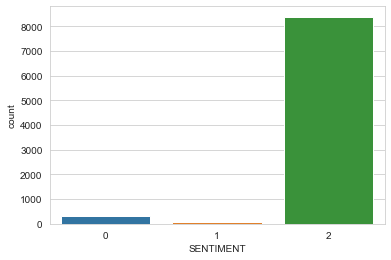

In [9]:
sns.countplot(dfXY.SENTIMENT)
plt.show()

### Highly imbalanced data
* Because of highly imbalanced data, we need to "balance" by using class weights while fitting any model

### take tokenized sentences and make it all integers using keras tokenizer on already tokenized data

In [10]:
# because embedding is independent of tokenization, we integerize our token based on keras tokenizer
num_expected_unique_words = 10000
keras_tokenizer = Tokenizer(num_expected_unique_words, split=",")
keras_tokenizer.fit_on_texts(dfXY['TOKENS'])

In [11]:
validation_reqd = True
X = dfXY.TOKENS
y = dfXY.SENTIMENT
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = contacts_utils.split_data(X, y, validation_reqd)

In [12]:
MAX_SEQ_LEN = 300
X_train=keras_tokenizer.texts_to_sequences(df_trainX) # this converts texts into some numeric sequences
X_train_pad=pad_sequences(X_train,maxlen=MAX_SEQ_LEN,padding='post') # this makes the length of all numeric sequences equal

X_test = keras_tokenizer.texts_to_sequences(df_testX)
X_test_pad = pad_sequences(X_test, maxlen = MAX_SEQ_LEN, padding = 'post')

if validation_reqd:
    X_val = keras_tokenizer.texts_to_sequences(df_validX)
    X_val_pad = pad_sequences(X_val, maxlen = MAX_SEQ_LEN, padding = 'post')
else:
    X_val = None
    X_val_pad = None

In [13]:
y_train = to_categorical(df_trainy.values,num_classes=3)
y_test = to_categorical(df_testy.values, num_classes=3)
if validation_reqd:
    y_val = to_categorical(df_validy.values, num_classes=3)
else:
    y_val = None

### Compute class weights based on training data to balance the dataset

In [14]:
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
sentiment_class_weights = dict(enumerate(class_weights))

{0: 7.460030165912519, 1: 34.34722222222222, 2: 0.3525051671299266}


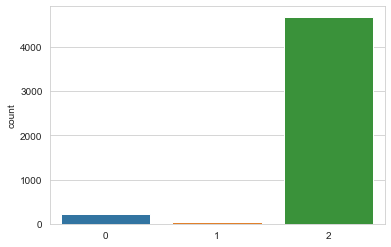

[ 221   48 4677]


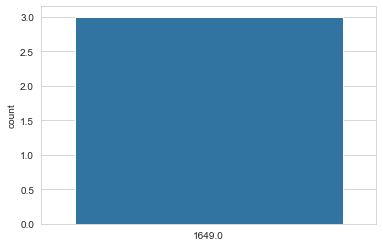

In [15]:
### Test if balancing has indeed taken place ...
print(sentiment_class_weights)
sns.countplot(y_integers)
plt.show()
print(np.bincount(y_integers))
balance_wts = np.array([val for k, val in sentiment_class_weights.items()])
bal = np.round(np.bincount(y_integers) * balance_wts)
sns.countplot(bal)
plt.show()

In [16]:
# train Gensim's Word2Vec model
gensim_model = Word2Vec(sentences=prep_comments.tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=4,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=5,                 # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=10,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=4,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                        )

In [17]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(29377, 100)

In [18]:
word_vectors_weights = gensim_model.wv.vectors
vocab_size, embedding_size = word_vectors_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 29377 - Embedding Dim: 100


In [19]:
# Some validation on the quality of the Word2Vec model
print(gensim_model.wv.most_similar('product', topn=3))
print(gensim_model.wv.most_similar('price', topn=3))
print(gensim_model.wv.most_similar('service', topn=3))
print(gensim_model.wv.most_similar('quality', topn=3))
print(gensim_model.wv.most_similar(positive=['comfort', 'fit'], negative=['dry'], topn=3))

def word2token(word):
    try:
        return gensim_model.wv.key_to_index[word]
    except KeyError:
        return 0

def token2word(token):
    return gensim_model.wv.index_to_key[token]

[('usual', 0.8879867792129517), ('order-excellent', 0.8785396218299866), ('complaints', 0.8769664764404297)]
[('receiving', 0.8908309936523438), ('reasonable', 0.8905296325683594), ('fee', 0.881421685218811)]
[('support', 0.93996661901474), ('customer', 0.9397777915000916), ('prompt', 0.9331716299057007)]
[('inexpensive', 0.9232524037361145), ('value', 0.9115257263183594), ('organization', 0.9075266122817993)]
[('fit-comfort', 0.8031266927719116), ('comfort-fit', 0.7908005714416504), ('great-comfort', 0.7645182609558105)]


In [20]:
gensim_weight_matrix = np.zeros((num_expected_unique_words ,embedding_size))
gensim_weight_matrix.shape

(10000, 100)

### Test key to index for word vectors ...

In [21]:
word_vectors[word_vectors.key_to_index['dry']]

array([-0.859958  ,  0.10891432,  0.20266844,  0.48209864, -0.39475745,
       -0.28785574, -1.2133123 , -0.4197501 ,  0.06869421,  0.39065352,
        1.0127939 ,  0.08647051,  0.27175426, -0.33130857,  0.13905016,
        0.12047565,  0.03113329, -0.37979478,  0.39154842, -1.1230236 ,
        0.71278787, -0.8252117 ,  0.6039472 ,  0.46692222, -0.10895959,
        0.234139  , -0.02213019, -0.03488781, -0.9470773 ,  0.24549192,
        0.5371419 ,  0.16232367, -1.0077201 ,  0.38812816,  1.1346464 ,
        0.05136909, -0.11040257, -0.29506373, -0.09823304, -0.5054806 ,
        0.20912102,  0.33863094, -0.5660926 , -0.09991271, -0.09845529,
        0.07901365,  0.51281095,  0.16426116,  0.28789186,  0.9900915 ,
        0.2828561 ,  0.06948158,  0.26931083, -0.26046148, -0.5167574 ,
        0.19462869,  0.2808489 , -0.46949738,  0.00373779, -0.13682464,
       -0.70754457,  0.6464051 , -0.09796079,  0.7518907 ,  0.49421513,
       -0.25413537,  0.01635708, -0.15504067,  0.37218818, -0.95

### map the index of the word (obtained by keras_tokenizer, which assigned interger values to words) to its weight matrix obtained from wrod embedding

In [22]:
for word, index in keras_tokenizer.word_index.items():
    if index < num_expected_unique_words: # why ? since index starts with zero
        try:
            word_index_in_embedding = word_vectors.key_to_index[word]
        except KeyError:
            gensim_weight_matrix[index] = np.zeros(embedding_size)
        else:
            gensim_weight_matrix[index] = word_vectors[word_index_in_embedding]

In [23]:
gensim_weight_matrix.shape

(10000, 100)

### RNN model

In [24]:
num_sentiments  = 3
print(f"input length:{X_train_pad.shape[1]}")

model = Sequential()
model.add(Embedding(input_dim = num_expected_unique_words,
                    output_dim = embedding_size,
                    input_length= X_train_pad.shape[1],
                    weights = [gensim_weight_matrix],
                    trainable = False))

model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100,return_sequences=False)))
model.add(Dense(num_sentiments, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = 'accuracy')

input length:300


2022-08-02 14:14:53.213189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
#EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./sentiment_RNN_model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [26]:
if validation_reqd:
    history_embedding = model.fit(X_train_pad, y_train,
                                  epochs = 2,
                                  batch_size = 120,
                                  validation_data=(X_val_pad, y_val),
                                  verbose = 1,
                                  callbacks= [es, mc],
                                  class_weight = sentiment_class_weights,
                                  workers=4,
                                  use_multiprocessing=True)
else:
    history_embedding = model.fit(X_train_pad, y_train,
                                  epochs = 2,
                                  batch_size = 120,
                                  verbose = 1,
                                  callbacks= [es, mc],
                                  class_weight = sentiment_class_weights,
                                  workers=4,
                                  use_multiprocessing=True)


_, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Accuracy of model is: {accuracy}')

Epoch 1/2
42/42 [==============================] - ETA: 0s - loss: 1.0933 - accuracy: 0.5416
Epoch 1: val_accuracy improved from -inf to 0.52213, saving model to ./sentiment_RNN_model.h5
42/42 [==============================] - 155s 4s/step - loss: 1.0933 - accuracy: 0.5416 - val_loss: 1.1786 - val_accuracy: 0.5221
Epoch 2/2
42/42 [==============================] - ETA: 0s - loss: 1.0140 - accuracy: 0.6187
Epoch 2: val_accuracy improved from 0.52213 to 0.69618, saving model to ./sentiment_RNN_model.h5
69/69 [==============================] - 22s 322ms/step - loss: 1.0071 - accuracy: 0.6317
Accuracy of model is: 0.6316507458686829


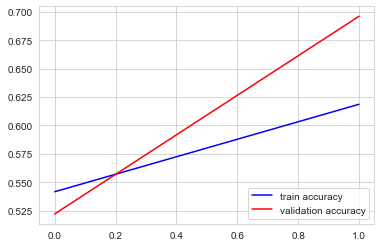

In [27]:
plt.plot(history_embedding.history['accuracy'],c='b',label='train accuracy')
plt.plot(history_embedding.history['val_accuracy'],c='r',label='validation accuracy')
plt.legend(loc='lower right')
plt.show()

In [28]:
y_pred_raw =model.predict(X_test_pad, workers=4, use_multiprocessing=True)

69/69 [==============================] - 23s 303ms/step


In [29]:
y_pred =   np.argmax(y_pred_raw, axis = 1)
y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(y_pred, y_true))
#
#y_pred = convert_prob_to_labels(y_pred_raw)
#print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.37      0.12      0.18       266
           1       0.28      0.01      0.02       555
           2       0.64      0.98      0.78      1378

    accuracy                           0.63      2199
   macro avg       0.43      0.37      0.32      2199
weighted avg       0.52      0.63      0.51      2199



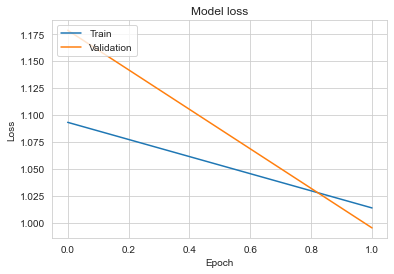

In [30]:
contacts_utils.plot_loss(history_embedding)

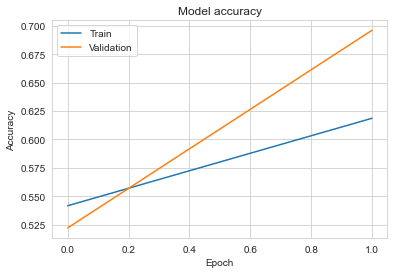

In [31]:
contacts_utils.plot_accuracy(history_embedding)

In [32]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):
    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0))

    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()

['dryer', 'usual', 'service', 'great-service', 'shelf', 'awhile', 'disappointed']


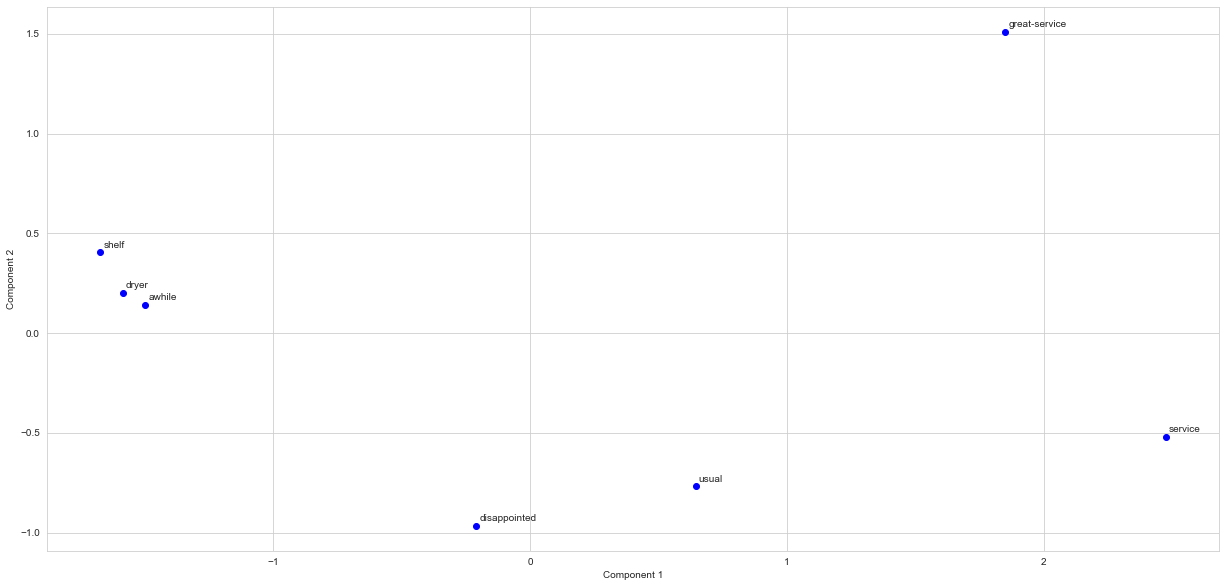

In [33]:
# define the tokens to use in the plot
tokens_of_interest = ['dryer', 'usual', 'service', 'great-service',  'shelf', 'awhile', 'disappointed']
print(tokens_of_interest)
# expand the list of tokens with all the tokens from the replacement dictionary
#tokens_of_interest = set(tokens_of_interest) + list(replacing_dict.values()) )

# plot
pca_scatterplot(word_vectors, tokens_of_interest)